# Unskewing COVID-19 Case Count with Phylodynamic and Epidemiological Parameters
Kartik Chugh - May 3, 2020

Over the past few months, the coronavirus pandemic has devastated communities on a global scale, with roughly 3.5 million cases worldwide and over a million in the United States alone at the time of this writing. Key to the virus' wildfire-like spread has been "cryptic transmission", whereby asymptomatic carriers pass it along unknowingly to others. The US, with its tepid testing and tracing measures and low governmental preparedness, is thought to have been particularly afflicted by this phenomenon for long periods of time: viral dynamics research suggests that the coronavirus must have been spreading silently across the nation for weeks before taking off in March.

 <img src="china-data.png" />

<sup>Chart from <a href="https://jamanetwork.com/journals/jama/fullarticle/2762130">Journal of the American Medical Association</a> pertains to the Hubei province of China. Orange bars indicate medical diagnoses of the coronavirus, while gray bars indicate development of symptoms (as reported by patients themselves). Symptomatic onset is one estimate of "true case count", though biased downwards because asymptomatic carriers are neglected. Still, notice the lag between "true cases" and their subsequent diagnoses days, if not weeks, later! This lag masked the problem from officials and the public.</sup>

In this project, I derive estimates for true case counts for the United States from January to present. My methodology is based on the work of [Tomas Pueyo](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca), whose estimation technique was endorsed by over 500 medical experts and virologists in March. I extend his core idea in three key ways: 
1. I bring it up to date, using all available case data to this point
2. I compute dynamic estimates of doubling time, allowing the model to account for social distancing measures
3. I adjust for biases using phylodynamic analyses performed by other researchers

In [27]:
import numpy as np
import pandas as pd
from pandas import Timestamp, Series
from pandas.plotting import register_matplotlib_converters
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.3f}'.format})
%config InlineBackend.figure_format = 'retina'
register_matplotlib_converters()

## Time-Varying Estimation of Doubling

I begin by pulling live data from the [COVID Tracking Project](https://covidtracking.com/api), which has made their datasets available through a free API. We're interested in two main statistics: daily deaths due to the virus, and cumulative confirmed case count.

In [35]:
url = 'https://covidtracking.com/api/v1/us/daily.csv'

df = pd.read_csv(url, 
            usecols=['date', 'positive', 'deathIncrease'], 
            parse_dates=['date'], 
            index_col=['date']).sort_index().iloc[1:]

time = df.index
confirmed = df['positive']
deathsDaily = df['deathIncrease']

In [3]:
df

,positive,deathIncrease
date,,
2020-01-23,1,0.0
2020-01-24,1,0.0
2020-01-25,1,0.0
2020-01-26,1,0.0
2020-01-27,1,0.0
...,...,...
2020-04-29,1033157,2700.0
2020-04-30,1062134,2091.0
2020-05-01,1095681,1743.0


Next, I use the daily growth in cases to compute estimates of doubling time: at the current rate, how many days it would take for cases to double. For this, we use

$$ T_{double} = \frac{ln(2)}{ln(\frac{c_t}{c_{t-1}})} $$ 

where $ c_t $ is the confirmed case count on a given day and $ c_{t-1} $ the day prior.

In [13]:
def doublingTime(a, b):
    return np.log(2)/np.log(b/a) if (a != b) else np.nan # avoids division by zero

# computes doubling times
doubling = np.full(confirmed.shape, np.nan)
for t in range(1, len(doubling)):
    doubling[t] = doublingTime(confirmed[t-1], confirmed[t])

# stores in dataframe
doubling_orig = pd.DataFrame(doubling, columns=['doubling time'], index=time)

However, case reports are known to be erratic due to testing backlogs and a variety of other factors. I apply a Gaussian filter to "de-noise" the data, as we can assume that the real, parametric doubling rate is not nearly as stochastic as the data. 

Moreover, computing doubling times this way can yield unusual values for early dates, like 0.46 for Feburary 28th. This is because even small jumps in data from zero or near-zero cases appear astronomically larger (e.g. going from 2 to 9 cases is technically a "quadrupling"). In reality, we know there's a biological limit to a virus' rate of spread. [Numerous studies](https://midasnetwork.us/covid-19/) have focused on pinpointing this lower bound; I select 2.45 as a more conservative estimate.

In [24]:
min_doubling = 2.45  

doubling_smooth = doubling_orig.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round().clip(lower=min_doubling).fillna(min_doubling)

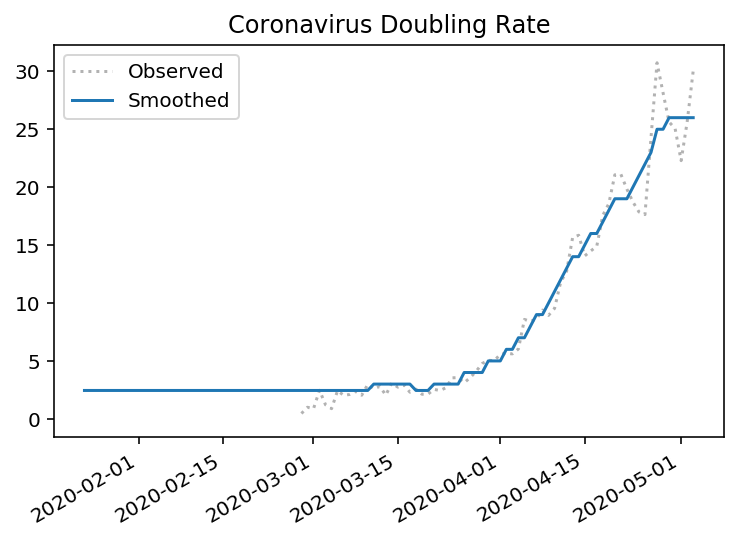

In [30]:
plt.plot(doubling_orig, c='k', ls=':', alpha=.3)
plt.plot(doubling_smooth)
plt.gcf().autofmt_xdate()
plt.legend(['Observed', 'Smoothed'])
plt.title('Coronavirus Doubling Rate')
plt.show()

## Backpropagation of Mortality

Recall the chart at the top of this page, displaying the time lag between onset of coronavirus (assessed retroactively) and official diagnosis from a medical official. While retroactive onset figures are more accurate than confirmed case counts, they still represent an undercount, as asymptomatic carriers fly under the radar. But there is a not-so-silent indicator of disease: death.

While apparent mortality in the US is 3-5%, this figure is considered biased upwards due to cases not reported. Researchers peg the true mortality rate at near 1.1%. And the other thing we know is how often it takes between contracting the virus to dying: [17 days](https://midasnetwork.us/covid-19/), on average.

In [41]:
MORTALITY = 0.011
MORTALITY_LAG = 17

From this, we can take the date of the first reported deaths in the US and estimate when the victims contracted the virus.

In [43]:
t_init = deathsDaily.ne(0).idxmax()
d_init = deathsDaily[t_init]
print("Date of First Deaths: " + str(t_init))
print("Number of Deaths: " + str(d_init))

t0 = t_init - timedelta(days=MORTALITY_LAG)

print("Estimated Contraction Date: " + str(t0))

Date of First Deaths: 2020-02-26 00:00:00
Number of Deaths: 2.0
Estimated Contraction Date: 2020-02-09 00:00:00


Using the mortality rate, we can say that if 2 people died from the coronavirus on the 26th, around 181 people had the disease 17 days earlier. 

In [50]:
c0 = d_init * 1/MORTALITY
print("True Case Count: " + str(c0.astype('int')))
print("Reported Case Count: " + str(confirmed[t0]))

True Case Count: 181
Reported Case Count: 2


Compare this to the known case count of 2 at the time, and we begin to understand how the country could be caught so flatflooted! By early Feburary, we had roughly the same number of true cases as we had confirmed cases _a full month later_.

In [116]:
c = np.full(df['positive'].shape, c0)

In [117]:
cf = 0.75

for t in range((t0-time[0]).days, -1, -1):
    db = doubling_smooth['doubling time'][t]
    C[t] = C[t+1] / 2**(1/db * cf)

for t in range((t0-time[0]).days, len(C)):
    db = doubling_smooth['doubling time'][t]
    C[t] = C[t-1] * 2**(1/db * cf)

In [118]:
C

array([4.053, 5.033, 6.250, 7.762, 9.639, 11.970, 14.865, 18.460, 22.925,
       28.470, 35.355, 43.906, 54.525, 67.713, 84.090, 104.427, 129.684,
       161.049, 200.000, 248.372, 308.442, 383.041, 475.683, 590.730,
       733.603, 911.031, 1131.371, 1405.002, 1744.812, 2166.809, 2690.869,
       3341.676, 4149.887, 5153.569, 6400.000, 7947.890, 9870.149,
       12257.322, 15221.851, 18903.375, 23475.304, 29152.989, 36203.867,
       44960.055, 55833.996, 69337.884, 86107.793, 106933.635, 127166.240,
       151226.997, 179840.221, 213867.271, 254332.480, 302453.995,
       359680.442, 446671.967, 554703.072, 688862.343, 819200.000,
       974198.469, 1158523.750, 1377724.687, 1638400.000, 1865791.299,
       2124741.926, 2419631.958, 2755449.374, 3057362.507, 3392356.102,
       3764054.770, 4104730.832, 4476240.713, 4821327.654, 5193018.391,
       5541679.727, 5871205.151, 6220325.177, 6552248.172, 6869341.556,
       7173473.289, 7466148.104, 7748599.382, 8041736.052, 8325327.262,


In [119]:
df['true'] = C.round()
df

,positive,deathIncrease,positiveIncrease,true
date,,,,
2020-01-23,1,0.0,0.0,4.0
2020-01-24,1,0.0,0.0,5.0
2020-01-25,1,0.0,0.0,6.0
2020-01-26,1,0.0,0.0,8.0
2020-01-27,1,0.0,0.0,10.0
2020-01-28,1,0.0,0.0,12.0
2020-01-29,1,0.0,0.0,15.0
2020-01-30,1,0.0,0.0,18.0
2020-01-31,1,0.0,0.0,23.0


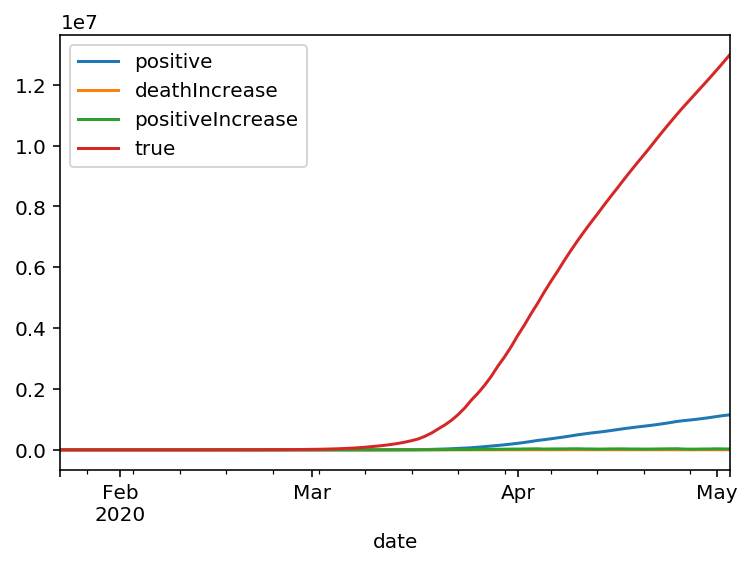

In [120]:
df.plot()